In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and concatenate data
df1 = pd.read_csv('data/cleaned/greater-vancouver-area-cleaned.csv')
df2 = pd.read_csv('data/cleaned/greater-toronto-area-cleaned.csv')
df = pd.concat([df1, df2], axis=0)


In [7]:
df.head()


,price,link,title,location,description,Nearest intersection,Bedrooms,Bathrooms,Unit type,Parking included,sqft,sqm
0,1950.0,/v-apartments-condos/delta-surrey-langley/guil...,Guildford Apartment For Rent | Mainstreet Estates,Delta/Surrey/Langley,Mainstreet Estates is professionally managed b...,150 Street / 107A Avenue,1.0,1.0,Apartment,0,625.0,58.064375
1,2245.0,/v-apartments-condos/burnaby-new-westminster/s...,Skyview Apartments - 1 Bdrm available at 908 S...,New Westminster,$500 Security Deposit Move in this month and y...,Eighth Street / Sixth Avenue,1.0,1.0,Apartment,0,595.0,55.277285
2,3400.0,/v-apartments-condos/richmond-bc/pet-friendly-...,Pet Friendly 3 beds 2 bath newly renovated hou...,Richmond,Well behaved pets welcome! Newly renovated hou...,No 1 Road / Tyson Place,3.0,1.5,House,2,1000.0,92.903000
3,3300.0,/v-apartments-condos/vancouver-downtown-west-e...,Westend Condo for Rent,Vancouver,"West of Denman reinforced concrete strata, loc...",Denman Street / Haro Street,2.0,1.0,Condo,1,780.0,72.464340
4,2499.0,/v-apartments-condos/vancouver/luxury-studio-i...,Luxury Studio in central Downtown,Vancouver,Please call 7783164156 This amazing downtown V...,Burrard Street / Comox Street,0.0,1.0,Apartment,1,500.0,46.451500


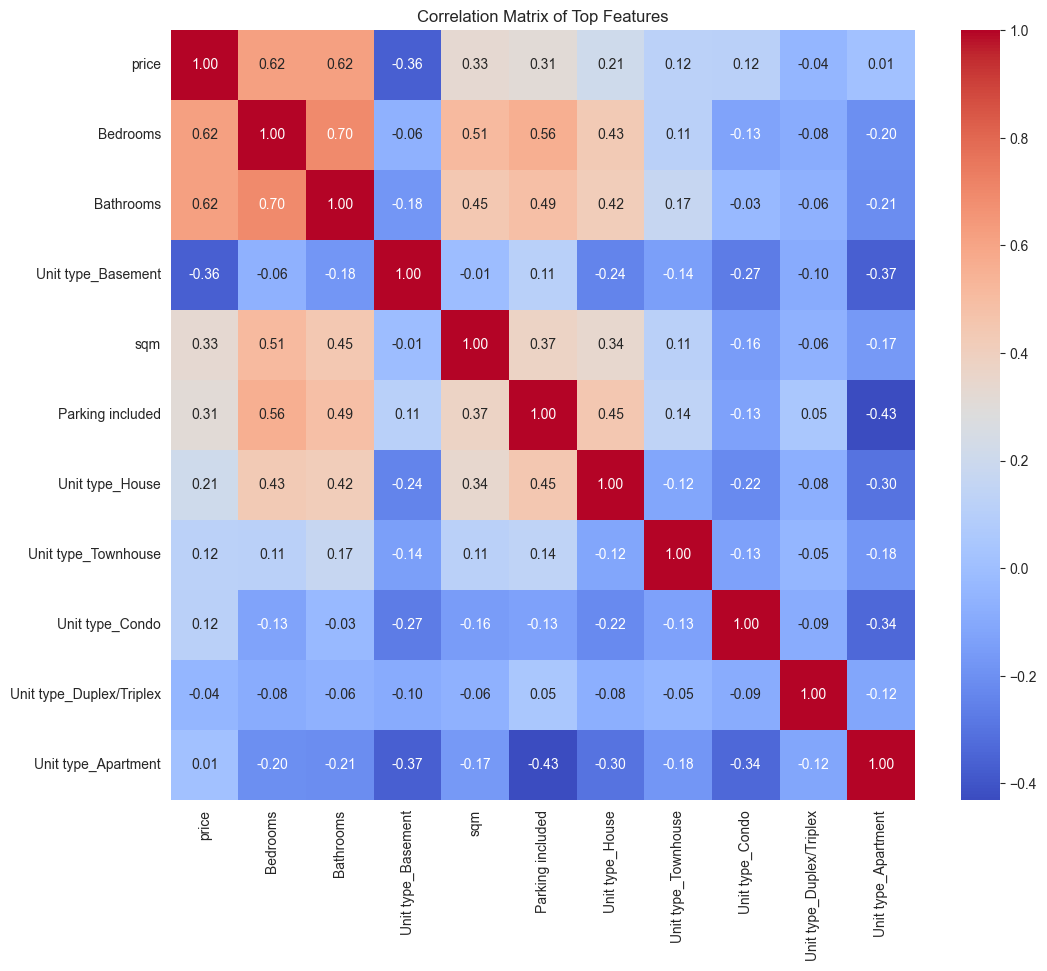

In [8]:
df.drop(columns=['sqft','link','description','Nearest intersection','title', 'location'], inplace=True)

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['Unit type'])

# Calculate the correlation matrix for all columns
correlation_matrix = df.corr()

# Select the top N features with the highest absolute correlation with 'price'
N = 20  # You can adjust this number based on your needs
top_features = correlation_matrix['price'].abs().sort_values(ascending=False).head(N).index

# Create a correlation matrix for the top features
top_correlation_matrix = df[top_features].corr()

# Plot the heatmap for the top features
plt.figure(figsize=(12, 10))
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top Features')
plt.show()


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame and 'price' is the target variable
X = df.drop(columns=['price'])
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Machine': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

    # Save the results
    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Adjusted R²': adj_r2
    }

# Convert the results to a DataFrame for easy visualization
results_df = pd.DataFrame(results).T
print(results_df)


                                  MSE        RMSE         MAE        R²  \
Linear Regression       279785.760139  528.947786  314.147855  0.543049   
Decision Tree           390575.809634  624.960646  247.819817  0.362105   
Random Forest           248347.993419  498.345255  215.521202  0.594394   
Support Vector Machine  406134.655835  637.286949  402.987536  0.336694   
K-Nearest Neighbors     225236.686847  474.591073  212.936089  0.632140   

                        Adjusted R²  
Linear Regression          0.540613  
Decision Tree              0.358705  
Random Forest              0.592232  
Support Vector Machine     0.333158  
K-Nearest Neighbors        0.630179  


# Realizarei as próximas etapas utilizando o K-Nearest Neighbors.
### para continuar, otimizarei os hiperparametros e realizarei a validação cruzada do modelo.


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from skopt import BayesSearchCV
from skopt.space import Integer
import matplotlib.pyplot as plt

# Load data
df1 = pd.read_csv('data/cleaned/greater-vancouver-area-cleaned.csv')
df2 = pd.read_csv('data/cleaned/greater-toronto-area-cleaned.csv')
df = pd.concat([df1, df2], axis=0)

# Example feature selection (dropping 'price' column as target)
X = df.drop(columns=['price', 'link', 'title', 'description', 'Nearest intersection', 'location'])
y = df['price']

# Encoding categorical variables if any
X = pd.get_dummies(X)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Define the model
knn = KNeighborsRegressor()

# Define the parameter space for Bayesian Optimization
search_spaces = {
    'n_neighbors': Integer(1, 30),
    'weights': ['uniform', 'distance'],
    'p': Integer(1, 2)
}
models = {
    'K-Nearest Neighbors': KNeighborsRegressor()
}

# Implement Bayesian Optimization
bayes_search = BayesSearchCV(estimator=knn, search_spaces=search_spaces, n_iter=30, cv=3, random_state=42, n_jobs=-1)
bayes_search.fit(X_train, y_train)

# Best parameters from Bayesian Optimization
print("Best parameters from Bayesian Optimization: ", bayes_search.best_params_)

# Use the best parameters from Bayesian Optimization for Grid Search
best_params = bayes_search.best_params_

param_grid = {
    'n_neighbors': [best_params['n_neighbors'] - 1, best_params['n_neighbors'], best_params['n_neighbors'] + 1],
    'weights': [best_params['weights']],
    'p': [best_params['p']]
}

# Perform Grid Search
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best parameters from Grid Search: ", grid_search.best_params_)

# Evaluate the model with the best parameters
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

results = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R²': r2,
    'Adjusted R²': adj_r2
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    mae_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

    mse = -np.mean(mse_scores)
    rmse = np.sqrt(mse)
    mae = -np.mean(mae_scores)
    r2 = np.mean(r2_scores)
    adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X.shape[1] - 1)

    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Adjusted R²': adj_r2
    }

# Convert the results to a DataFrame for easy visualization
results_df_treated = pd.DataFrame(results).T
results_df_treated

Best parameters from Bayesian Optimization:  OrderedDict([('n_neighbors', 13), ('p', 1), ('weights', 'uniform')])
Best parameters from Grid Search:  {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}


,MSE,RMSE,MAE,R²,Adjusted R²
MSE,217886.508557,217886.508557,217886.508557,217886.508557,217886.508557
RMSE,466.783149,466.783149,466.783149,466.783149,466.783149
MAE,212.976218,212.976218,212.976218,212.976218,212.976218
R²,0.641735,0.641735,0.641735,0.641735,0.641735
Adjusted R²,0.640897,0.640897,0.640897,0.640897,0.640897
K-Nearest Neighbors,210526.253535,458.831400,237.808958,0.634588,0.634161
